In [1]:
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import cv2
import os
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
from Utils import *
from open3d.web_visualizer import draw
from VisulizerTools import *
from DDBSCAN import Raster_DBSCAN
import threading

import time
plt.rcParams["font.family"] = "Times New Roman"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [ ]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-19-14-30-0.pcap'
end_frame = 2000
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

  8%|██████▌                                                                        | 165/2000 [00:06<01:13, 25.06it/s]

In [60]:
def get_thred(temp,N = 20,d_thred = 0.1,d = 0.3,bck_n = 3):
    temp = temp.copy()
    total_sample = len(temp)
    bck_ds = []
    bck_portions = []
    repeat = 0
    while repeat < N:
        if len(temp) == 0:
            break
        sample = np.random.choice(temp,replace=False)
        ind = np.abs(temp - sample) < d
        portion = ind.sum()/total_sample
        if portion > d_thred:
            bck_portions.append(portion)
            bck_ds.append(sample)
            temp = temp[~ind]
        repeat += 1
    bck_ds = np.array(bck_ds)
    bck_portions = np.array(bck_portions)
    arg_ind = np.argsort(bck_portions)[::-1]
    bck_ds_ = bck_ds[arg_ind[:bck_n]]
    if len(bck_ds_) < bck_n:
        bck_ds_ = np.concatenate([bck_ds_,-d * np.ones(bck_n - len(bck_ds_))])
    return bck_ds_

In [61]:
def gen_bckmap(aggregated_maps):
    thred_map = np.zeros((3,32,1800))
    with tqdm(total=32*1800) as pbar:
        for i in range(thred_map.shape[1]):
            for j in range(thred_map.shape[2]):
                thred_map[:,i,j] = get_thred(aggregated_map[:,i,j])
#                 print(i,j)
                pbar.update(1)
    return thred_map

In [62]:
a = time.time()
thred_map = gen_bckmap(aggregated_map)
time.time() - a

100%|██████████████████████████████████████████████████████████████████████████| 57600/57600 [00:13<00:00, 4284.88it/s]


13.443619966506958

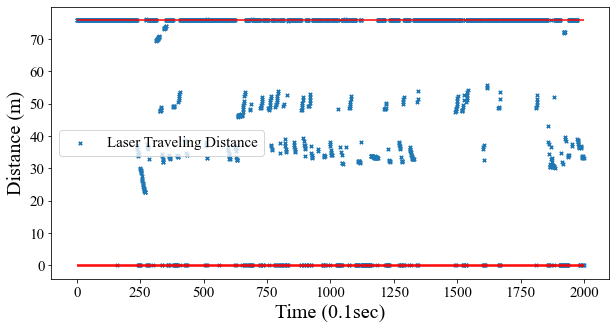

In [31]:
laser_id = 14
azimuth_channel = 51
temp = aggregated_map[:,laser_id,azimuth_channel].copy()
bck_ds = thred_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 12, marker = 'x', label = "Laser Traveling Distance")
for b in bck_ds:
    plt.hlines(b,0,2000, color = 'r')
plt.legend(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Distance (m)',fontsize = 20)
plt.xlabel('Time (0.1sec)',fontsize = 20)

# plt.ylim(17.5,19)
# plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\ITSmanuscript\Figs\Picture5.tif', dpi = 600)
plt.show()

In [47]:
db = Raster_DBSCAN(window_size=[7,11],eps = 1.1,min_samples= 5,Td_map_szie=(32,1800))

In [48]:
def show_result(Td_map):
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    pcd = get_pcd_colored(Td_map,Labeling_map)
    draw(pcd,width=1000,height=1000)
    return Labeling_map

In [112]:
pcd = get_pcd_colored_specified(Td_map_next,Labeling_map_next,[3])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_15')

In [33]:
Td_map = aggregated_map[370].copy()
Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
pcd = get_pcd_colored_specified(Td_map,Labeling_map,[6])
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_18')

In [31]:
pd.DataFrame(Foreground_map).to_csv(r'D:\Test\Foreg1.csv',index = False)

In [56]:
pd.DataFrame(Labeling_map).to_csv(r'D:\Test\LABEL1.csv',index = False)

In [63]:
def get_xy_set(new_uni_labels,Labeling_map,Td_map,if_app):
    xy_set = [] # xy position and apperance features
    if if_app:
        apperance_set = []
    for label in new_uni_labels:
        rows,cols = np.where(Labeling_map == label)
        rows_temp,cols_temp = rows.copy(),cols.copy()
        sort_ind = np.argsort(cols)
        refer_cols = cols[sort_ind[[0,-1]]]
        # this is being said, the first place is for less azimuth id 
        refer_rows = rows[sort_ind[[0,-1]]]
        if np.abs(refer_cols[0] - refer_cols[1]) >= 900:
            cols[cols <= 900] += 1800
            sort_ind = np.argsort(cols)
            refer_cols = cols[sort_ind[[0,-1]]]
            refer_cols[refer_cols >= 1800] -= 1800
            refer_rows = rows[sort_ind[[0,-1]]]
        if if_app:
            apperance = get_appearance_features(rows_temp,cols_temp,Td_map)
            apperance_set.append(apperance)
        xy = get_representative_point(refer_rows,refer_cols,Td_map) # x,y vec for two representatives 
        xy_set.append(xy)
    xy_set = np.array(xy_set)
    if if_app:
        apperance_set = np.array(apperance_set)
        return xy_set,apperance_set
    else:
        return xy_set

In [64]:
def extract_xy(Labeling_map,Td_map):
        
    # Plane_model is a 1 x 4 array representing a,b,c,d in ax + by + cz + d = 0 
    new_uni_labels = np.unique(Labeling_map[Labeling_map != -1])
    xy_set = get_xy_set(new_uni_labels,Labeling_map,Td_map,False)
    
    total_labels = np.concatenate([new_uni_labels,new_uni_labels])
    edge_points = np.concatenate([xy_set[:,1,:,0],xy_set[:,0,:,0]])
    merge_labels = db_merge.fit_predict(edge_points)
    unique_merge_labels = np.unique(merge_labels[merge_labels != -1])
    merge_pairs = [total_labels[merge_labels == l] for l in unique_merge_labels]
    for p in merge_pairs:
        merging_p = np.unique(p)
        if len(merging_p) > 1:
            for i in range(1,len(merging_p)):
                Labeling_map[Labeling_map == merging_p[i]] = merging_p[0]
    new_uni_labels = np.unique(Labeling_map[Labeling_map != -1])
    xy_set,apperance_set = get_xy_set(new_uni_labels,Labeling_map,Td_map,True)
    
    return xy_set,apperance_set,new_uni_labels,Labeling_map

In [157]:
Td_map_next = aggregated_map[1].copy()
Labeling_map_next = show_result(Td_map_next)

WebVisualizer(window_uid='window_26')

In [197]:
pcd = get_pcd_colored_specified(Td_map_next,Labeling_map_next,np.arange(8,9))
draw(pcd,width=1000,height=1000)

WebVisualizer(window_uid='window_29')

In [110]:
xy_set,apperance_set,new_uni_labels,Labeling_map = extract_xy(Labeling_map_next,Td_map_next)
pcd = get_pcd_colored_specified(Td_map_next,Labeling_map_next,[6])
points = np.asarray(pcd.points)

In [77]:
test_traj = []

In [112]:
test_traj.append(xy_set[new_uni_labels == 8])

In [114]:
test_traj = np.array(test_traj)

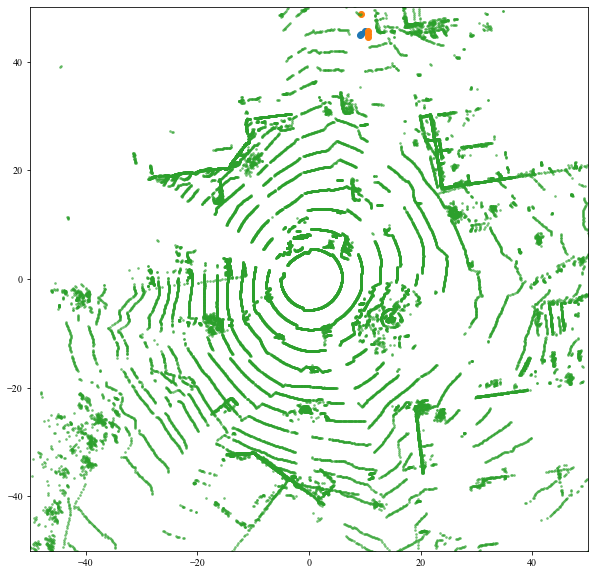

In [199]:
plt.figure(figsize=(10,10))
plt.scatter(test_traj[:,0,0,:,0][:,0],test_traj[:,0,0,:,0][:,1])
plt.scatter(test_traj[:,0,1,:,0][:,0],test_traj[:,0,1,:,0][:,1])
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.show()

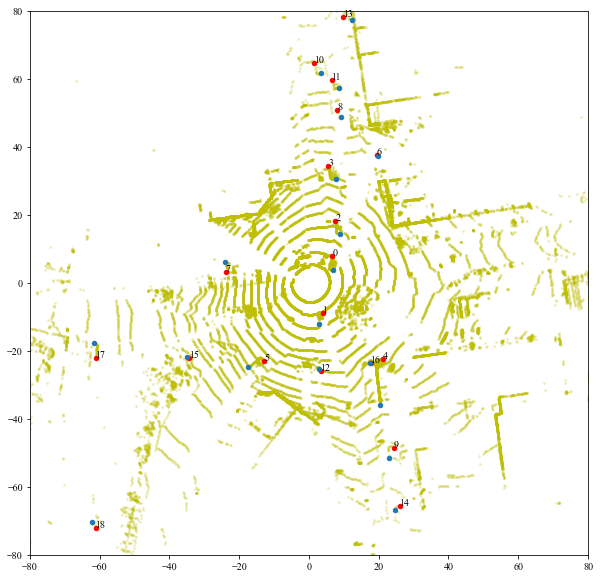

In [213]:
plt.figure(figsize=(10,10))
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.2, c = 'y')
plt.scatter(xy_set[:,0,:,0][:,0],xy_set[:,0,:,0][:,1],s = 20,c = 'r')
plt.scatter(xy_set[:,1,:,0][:,0],xy_set[:,1,:,0][:,1],s = 20)
for i in range(xy_set.shape[0]):
    plt.annotate(i,xy_set[:,0,:,0][i])
plt.ylim(-80,80)
plt.xlim(-80,80)
plt.show()

In [ ]:
def show_result(Td_map):
    Foreground_map = ~(np.abs(Td_map - thred_map) <= 0.3).any(axis = 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    pcd = get_pcd_colored(Td_map,Labeling_map)
    draw(pcd,width=1000,height=1000)
    return Labeling_map

In [175]:
with open(r'D:\Test\test_kal_td.pickle', 'rb') as handle:
    Off_tracking_pool = pickle.load(handle)

In [176]:
keys = [key for key in Off_tracking_pool.keys()]
lenths = [len(Off_tracking_pool[key].mea_seq) for key in Off_tracking_pool.keys()]
lenths = np.array(lenths)
keys = np.array(keys)

In [177]:
key = 5
meas = []
mea_seq = Off_tracking_pool[key].mea_seq
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  Off_tracking_pool[key].post_seq
post_seq = np.array(post_seq)
print(Off_tracking_pool[key].start_frame)
print(Off_tracking_pool[key].start_frame + len(post_seq))

1
167


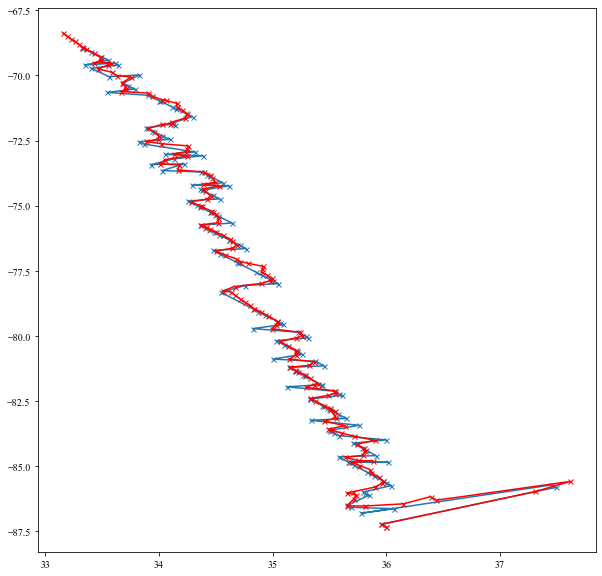

In [178]:
plt.figure(figsize=(10,10))
plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5, )
plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'r')
# plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5)

# plt.xlim(35,45)
# plt.ylim(-58,-56)
plt.show()

In [179]:
app_col_names = ['Point_Cnt','Dir_X_Bbox','Dir_Y_Bbox','Height','Length','Width','Area','Dis']

In [180]:
def get_summary_file_TR(post_seq,key,start_frame,app_seq,P_seq,T):
    temp = np.array(post_seq)
    temp = temp.reshape((temp.shape[0],temp.shape[1],temp.shape[2]))
    # n x 2 x 6
    temp_xy = temp[:,:,:2]
    # n x 2 x 2
    dis_est = np.sqrt((temp_xy[:,:,0]**2 + temp_xy[:,:,1]**2))
    # n x 2 
    speed_xy = temp[:,:,2:4] * 10 
    # n x 2 x 2
    speed = np.sqrt((speed_xy[:,:,0]**2 + speed_xy[:,:,1]**2))
    # n x 2
    xyz_0 = np.concatenate([temp_xy[:,0],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
    xyz_1 = np.concatenate([temp_xy[:,1],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
    xyz = (xyz_0 + xyz_1)/2
    LLH_est = convert_LLH(xyz,T)
    est = np.concatenate([xyz_0,dis_est[:,0].reshape(-1,1),speed_xy[:,0],speed[:,0].reshape(-1,1),LLH_est],axis = 1)
    # x,y,z,d,s_x,s_y,s,L,L,H
    timestp = []
    for i in range(len(temp)):
        f = i + start_frame + 1
        timestp.append('%06.0f'%f)
    timestp = np.array(timestp).reshape(-1,1)
    objid = (np.ones(len(temp)) * key).astype(int).reshape(-1,1)
    summary = np.concatenate([objid,timestp,est],axis = 1)
    # obj_id,ts,x,y,z,d,s_x,s_y,s,L,L,H
    summary = pd.DataFrame(summary,columns = column_names_TR_2o)

    emp = []
    for app in app_seq:
        if type(app) == int:
            emp_row = np.empty(len(app_col_names))
            emp_row[:] = np.nan
            emp.append(emp_row)
        else:
            emp.append(app.flatten())

    app_df = pd.DataFrame(emp,columns = app_col_names)
    P_seq = np.array(P_seq)
    confident_app = app_df.iloc[P_seq[:,0,0,0] < 0.5]
    max_length = confident_app.Length.max()
    if np.isnan(max_length):
        max_length = 0
    app_df.Length = max_length

    return summary,app_df

In [181]:
ref_LLH,ref_xyz = pd.read_csv(r'D:\LiDAR_Data\MidTown\Roundabout\Calibration\LLE_ref.csv'),pd.read_csv(r'D:\LiDAR_Data\MidTown\Roundabout\Calibration\xyz_ref.csv')
ref_LLH,ref_xyz = np.array(ref_LLH),np.array(ref_xyz)
if len(np.unique(ref_xyz[:,2])) == 1:
    np.random.seed(1)
    offset = np.random.normal(-0.521,3.28,len(ref_LLH))
    ref_xyz[:,2] += offset
    ref_LLH[:,2] += offset
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808
T = generate_T(ref_LLH,ref_xyz)

In [182]:
def save_result(Off_tracking_pool,ref_LLH,ref_xyz,f_path):

    if len(Off_tracking_pool) == 0:
        print('No Trajs Here')
    else:
        # print('Generating Traj Files...')
        T = generate_T(ref_LLH,ref_xyz)
        sums = []
        app_dfs = []
        keys = []
        start_frame = []
        lengths = []
        for key in Off_tracking_pool:  
            sum_file,app_df = get_summary_file_TR(Off_tracking_pool[key].post_seq,
                                        key,Off_tracking_pool[key].start_frame,Off_tracking_pool[key].app_seq,Off_tracking_pool[key].P_seq,T) 
            sums.append(sum_file)
            app_dfs.append(app_df)
            keys.append(key)
            start_frame.append(Off_tracking_pool[key].start_frame)   
            lengths.append(len(sum_file))   

        sums = pd.concat(sums)
        app_dfs = pd.concat(app_dfs)
        sums = sums.reset_index(drop=True).astype('float64')
        app_dfs = app_dfs.reset_index(drop=True).astype('float64')

        classifier = pickle.load(open('./Classifier/Classifier.sav', 'rb'))
        X_test = np.array(app_dfs.loc[:,['Point_Cnt','Height','Length','Area']])
        pred = classifier.predict(X_test)
        sums = pd.concat([sums,app_dfs,pd.DataFrame(pred.reshape(-1,1),columns=['Class'])],axis = 1)
        sums.to_csv(f_path,index = False)

In [215]:
save_result(Off_tracking_pool,ref_LLH,ref_xyz,r'D:\Test\test.csv')

In [216]:
data = pd.read_csv(r'D:\Test\test.csv') # path to result

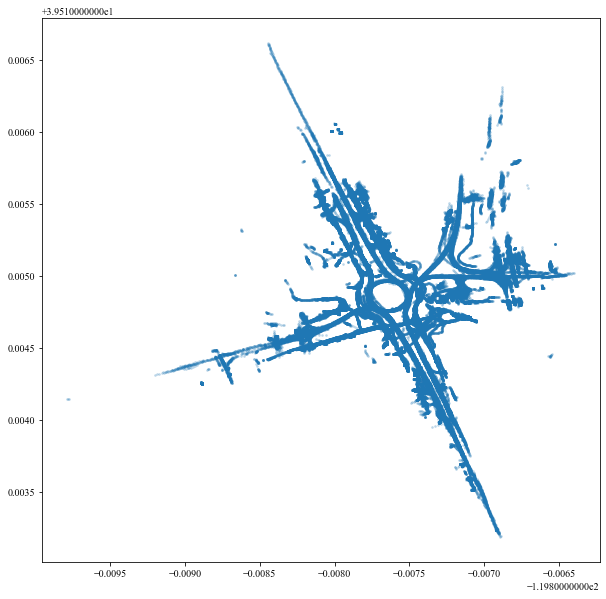

In [185]:
plt.figure(figsize=(10,10))
plt.scatter(data.loc[data.Class == 1,'Longitude'],data.loc[data.Class == 1,'Latitude'], s = 3, alpha = 0.2,label = 'Veh')

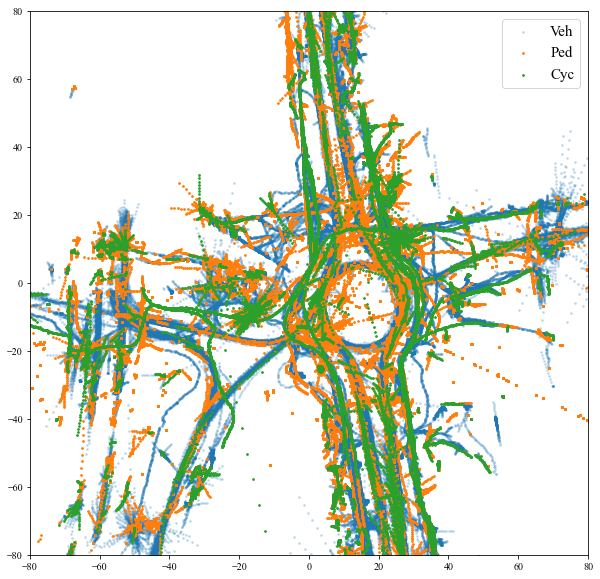

In [219]:
# data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(data.loc[data.Class == 1,'Coord_X'],data.loc[data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(data.loc[data.Class == 2,'Coord_X'],data.loc[data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(data.loc[data.Class == 3,'Coord_X'],data.loc[data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()

In [255]:
group_iter = data.groupby('ObjectID')
trajs = []
for i,g in group_iter:
    if len(g) < 10:
        continue
    votes = []
    for c in range(1,4):
        temp = test_traj.loc[test_traj.Class == c]
        votes.append(len(temp))
    g.Class = np.argmax(c) + 1
    trajs.append(g)
post_data = pd.concat(trajs)

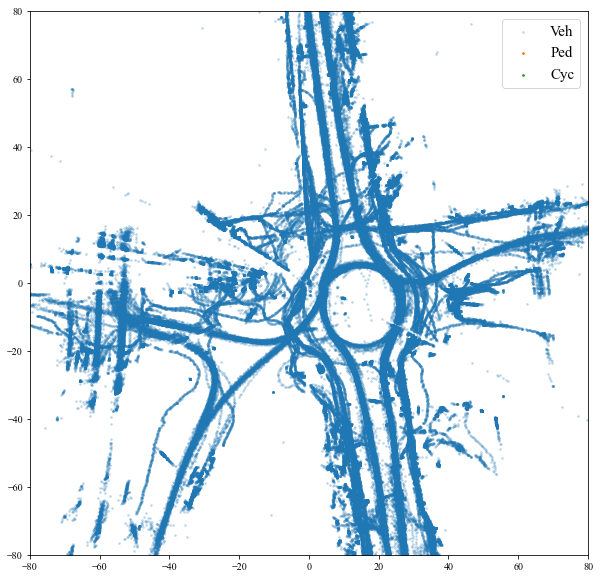

In [256]:
# post_data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(post_data.loc[post_data.Class == 1,'Coord_X'],post_data.loc[post_data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(post_data.loc[post_data.Class == 2,'Coord_X'],post_data.loc[post_data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(post_data.loc[post_data.Class == 3,'Coord_X'],post_data.loc[post_data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()

## Analysis tool

In [13]:
aggregated_map = []
Inten_maps = []
pcap_path = r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-19-14-30-0.pcap'
end_frame = 200
lidar_reader = TDmapLoader(pcap_path)
frame_gen = lidar_reader.frame_gen()
for i in tqdm(range(end_frame)):
    Frame = next(frame_gen)
    if Frame is None:
        break 
    Td_map,Int_map = Frame
    aggregated_map.append(Td_map)
    Inten_maps.append(Int_map)
aggregated_map = np.array(aggregated_map)
Inten_maps = np.array(Inten_maps)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 27.05it/s]


In [204]:
with open(r'D:\Test\test_kal_td.pickle', 'rb') as handle:
    Off_tracking_pool = pickle.load(handle)

In [205]:
valid_keys = []
for key in Off_tracking_pool.keys():
    length = len(Off_tracking_pool[key].mea_seq)
    post_seq = Off_tracking_pool[key].post_seq
    dis = np.mean(np.sqrt(np.sum(((post_seq[0] - post_seq[-1])**2)[:,:2],axis = 1)))
    if (dis > 5) & (length > 10):
        valid_keys.append(key)

In [206]:
key = valid_keys[103]
mea_seq = Off_tracking_pool[key].mea_seq
meas = []
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  np.array(Off_tracking_pool[key].post_seq)
app_seq = np.array(Off_tracking_pool[key].app_seq)
print(Off_tracking_pool[key].start_frame)
print(Off_tracking_pool[key].start_frame + len(post_seq))

522
538


In [207]:
pcd = get_pcd_colored(aggregated_map[0],np.ones_like(aggregated_map[0]))
points = np.asarray(pcd.points)

In [172]:
for key in valid_keys:
    plt.figure(figsize=(10,10))
    mea_seq = Off_tracking_pool[key].mea_seq
    meas = []
    for i in range(len(mea_seq)):
        if type(mea_seq[i]) == int:
            continue
        else:
            meas.append(mea_seq[i])
    meas = np.array(meas)
    post_seq =  np.array(Off_tracking_pool[key].post_seq)
    plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5,c = 'g' )
    plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'b')
    plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
    plt.savefig(r'D:\Test\TrajFigs\{}.png'.format(key))
    plt.close()
#     plt.show()

In [62]:
np.set_printoptions(suppress=True)

In [161]:
P_seq[230]

array([[[0.3236068 , 0.        , 0.07236068, 0.        ],
        [0.        , 0.3236068 , 0.        , 0.07236068],
        [0.07236068, 0.        , 0.05472136, 0.        ],
        [0.        , 0.07236068, 0.        , 0.05472136]],

       [[0.3236068 , 0.        , 0.07236068, 0.        ],
        [0.        , 0.3236068 , 0.        , 0.07236068],
        [0.07236068, 0.        , 0.05472136, 0.        ],
        [0.        , 0.07236068, 0.        , 0.05472136]]])

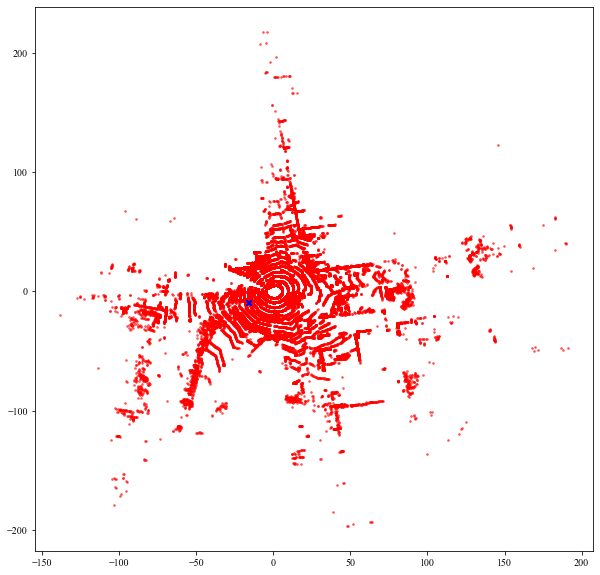

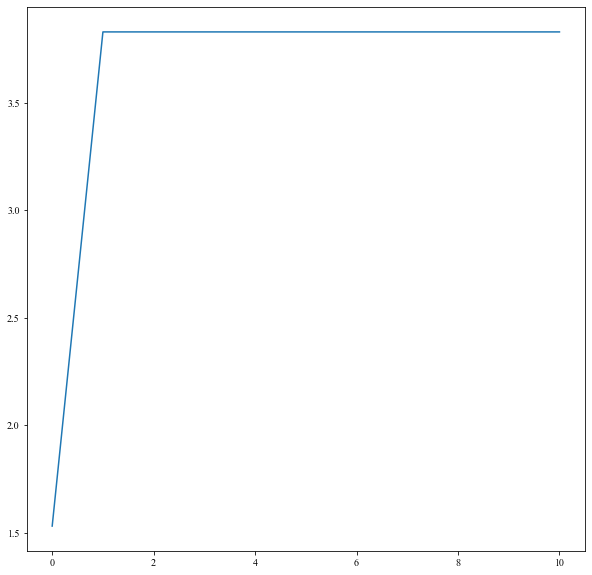

In [214]:
key = 30
plt.figure(figsize=(10,10))
mea_seq = Off_tracking_pool[key].mea_seq
meas = []
for i in range(len(mea_seq)):
    if type(mea_seq[i]) == int:
        continue
    else:
        meas.append(mea_seq[i])
meas = np.array(meas)
post_seq =  np.array(Off_tracking_pool[key].post_seq)
P_seq = np.array(Off_tracking_pool[key].P_seq)
plt.plot(meas[:,0,0,0],meas[:,0,1,0], marker = 'x', markersize = 5,c = 'g' )
plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'b')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
# plt.savefig(r'D:\Test\TrajFigs\{}.png'.format(key))
plt.show()
plt.figure(figsize=(10,10))
plt.plot(P_seq[:,0,0,0])
# plt.ylim(0,2.5)
plt.show()

In [200]:
S,P = state_predict(A,Q,post_seq[226],P_seq[226])

In [203]:
S,P = state_predict(A,Q,S,P)
print(P)

[[[15.46026311  0.          6.20652476  0.        ]
  [ 0.         15.46026311  0.          6.20652476]
  [ 6.20652476  0.          4.04472136  0.        ]
  [ 0.          6.20652476  0.          4.04472136]]

 [[15.46026311  0.          6.20652476  0.        ]
  [ 0.         15.46026311  0.          6.20652476]
  [ 6.20652476  0.          4.04472136  0.        ]
  [ 0.          6.20652476  0.          4.04472136]]]


In [198]:
P_seq[226]

array([[[0.1236068 , 0.        , 0.02763932, 0.        ],
        [0.        , 0.1236068 , 0.        , 0.02763932],
        [0.02763932, 0.        , 0.04472136, 0.        ],
        [0.        , 0.02763932, 0.        , 0.04472136]],

       [[0.1236068 , 0.        , 0.02763932, 0.        ],
        [0.        , 0.1236068 , 0.        , 0.02763932],
        [0.02763932, 0.        , 0.04472136, 0.        ],
        [0.        , 0.02763932, 0.        , 0.04472136]]])

In [197]:
P

array([[[0.3236068 , 0.        , 0.07236068, 0.        ],
        [0.        , 0.3236068 , 0.        , 0.07236068],
        [0.07236068, 0.        , 1.04472136, 0.        ],
        [0.        , 0.07236068, 0.        , 1.04472136]],

       [[0.3236068 , 0.        , 0.07236068, 0.        ],
        [0.        , 0.3236068 , 0.        , 0.07236068],
        [0.07236068, 0.        , 1.04472136, 0.        ],
        [0.        , 0.07236068, 0.        , 1.04472136]]])

In [155]:
distance.mahalanobis(mea_seq[227][0].flatten(),S[0].flatten()[:2],np.linalg.inv(P[0][:2,:2]))

110.79402388052887

In [144]:
P

array([[[1.85289586, 0.        , 1.43279303, 0.        ],
        [0.        , 1.85289586, 0.        , 1.43279303],
        [1.43279303, 0.        , 2.29320552, 0.        ],
        [0.        , 1.43279303, 0.        , 2.29320552]],

       [[1.85289586, 0.        , 1.43279303, 0.        ],
        [0.        , 1.85289586, 0.        , 1.43279303],
        [1.43279303, 0.        , 2.29320552, 0.        ],
        [0.        , 1.43279303, 0.        , 2.29320552]]])

In [145]:
P_seq[226]

array([[[0.1236068 , 0.        , 0.02763932, 0.        ],
        [0.        , 0.1236068 , 0.        , 0.02763932],
        [0.02763932, 0.        , 0.04472136, 0.        ],
        [0.        , 0.02763932, 0.        , 0.04472136]],

       [[0.1236068 , 0.        , 0.02763932, 0.        ],
        [0.        , 0.1236068 , 0.        , 0.02763932],
        [0.02763932, 0.        , 0.04472136, 0.        ],
        [0.        , 0.02763932, 0.        , 0.04472136]]])

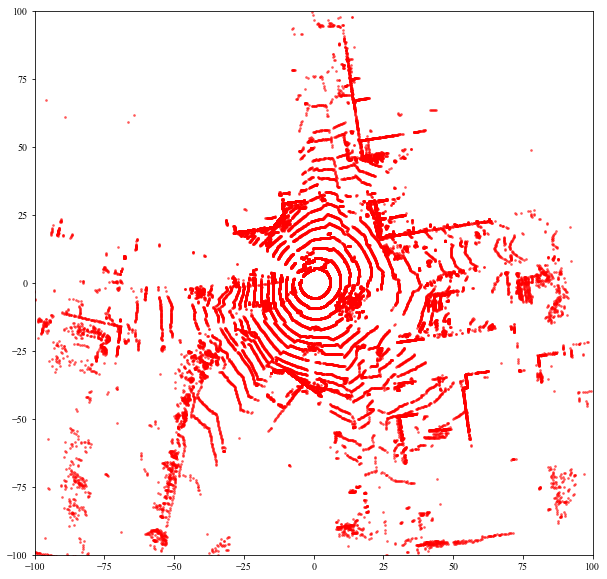

In [165]:
plt.figure(figsize=(10,10))
plt.plot(meas[400:,0,0,0],meas[400:,0,1,0], marker = 'x', markersize = 5, )
# plt.plot(post_seq[:,0,0,0],post_seq[:,0,1,0], marker = 'x', markersize = 5,c = 'r')
plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.5 , c = 'r')
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.show()

In [218]:
group_iter = data.groupby('ObjectID')
trajs = []
for i,g in group_iter:
    if len(g) < 20:
        continue
    dis = np.sqrt(np.sum(((np.array(g.iloc[0,[2,3]]) - np.array(g.iloc[-1,[2,3]]))**2)))
    if dis < 10:
        continue
    trajs.append(g)
post_data = pd.concat(trajs)

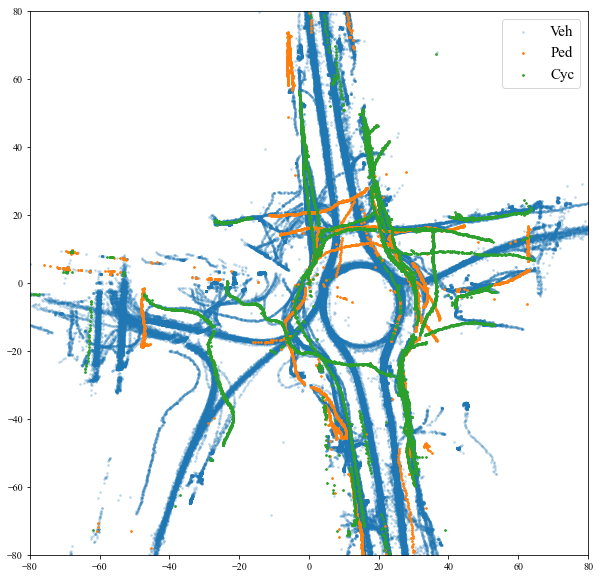

In [219]:
# post_data = pd.read_csv(r'D:\Test\test.csv') # path to result
plt.figure(figsize=(10,10))
plt.scatter(post_data.loc[post_data.Class == 1,'Coord_X'],post_data.loc[post_data.Class == 1,'Coord_Y'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(post_data.loc[post_data.Class == 2,'Coord_X'],post_data.loc[post_data.Class == 2,'Coord_Y'], s = 3, label = 'Ped')
plt.scatter(post_data.loc[post_data.Class == 3,'Coord_X'],post_data.loc[post_data.Class == 3,'Coord_Y'], s = 3,label = 'Cyc')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.legend(fontsize = 15)
plt.show()